# Fine tune LayoutLMv3 on custom dataset

## Load data
### Import relevant modules

In [44]:
from datasets import load_from_disk

In [45]:

dataset = load_from_disk("C:/Projects/IDP/watercare/dataset/23_11_03_01")


In [46]:
dataset["test"]

Dataset({
    features: ['tokens', 'bboxes', 'ner_tags', 'image', 'id'],
    num_rows: 8
})

In [47]:
example = dataset['train'][1]
example

{'tokens': ['Details',
  'Charge',
  'details',
  'Consumption',
  'charges',
  'Unit',
  'rate',
  'Water',
  '31.00',
  'kL',
  '$1.998/kL',
  '$',
  '61.94',
  'Wastewater',
  '24.34',
  'kL',
  '$3.476/kL',
  '$',
  '84.61',
  '$',
  '146.55',
  'Consumption',
  'details',
  'Meter',
  'no.',
  'X19A613028',
  '-',
  'Consumption',
  'period',
  '29',
  'days',
  'This',
  'reading',
  '22-Sep-23',
  '730',
  'Actual',
  'Last',
  'reading',
  '24-Aug-23',
  '699',
  'Estimate',
  'Consumption',
  '31.00kL',
  'Water',
  '31.00kL',
  'Wastewater',
  '@78.50%',
  '24.34kL'],
 'bboxes': [[106, 63, 179, 76],
  [109, 88, 157, 97],
  [163, 88, 205, 95],
  [109, 100, 194, 108],
  [199, 100, 249, 108],
  [321, 100, 346, 106],
  [351, 100, 373, 106],
  [106, 109, 144, 121],
  [263, 111, 295, 117],
  [301, 111, 313, 117],
  [321, 111, 379, 119],
  [427, 111, 433, 119],
  [438, 111, 470, 117],
  [108, 119, 178, 132],
  [263, 122, 295, 128],
  [301, 122, 313, 128],
  [321, 121, 379, 129],
  [

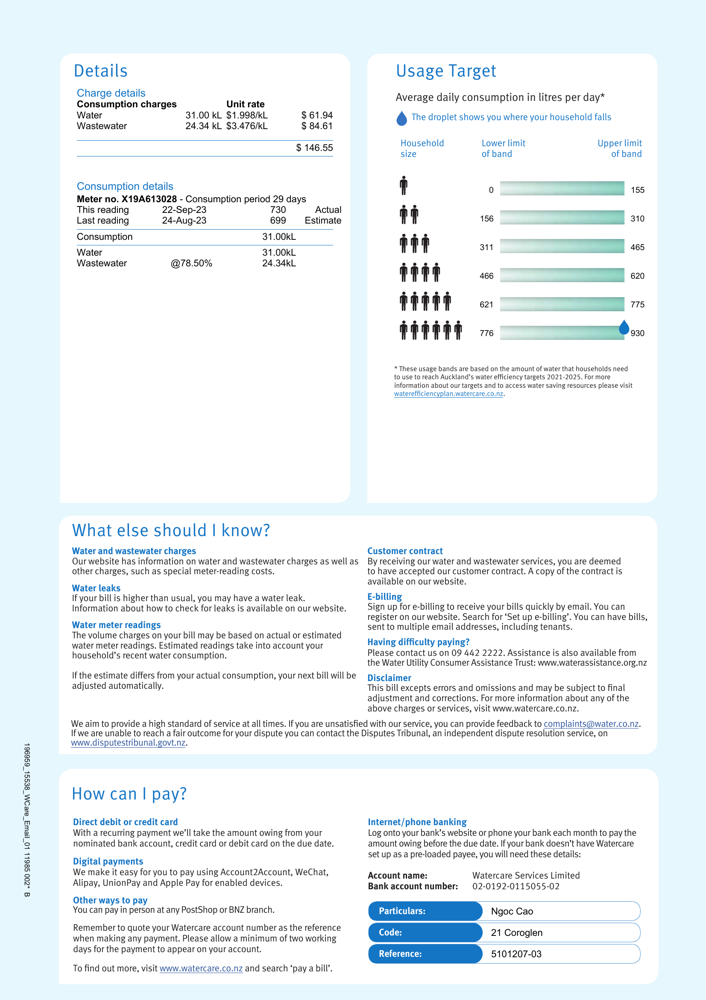

In [48]:
example['image']

## Setup Processor

In [49]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

# LayoutLMv3ImageProcessor - handles resize, normalize, change mode, rescale of image before passing to model
# LayoutLMv3TokenizerFast - Tokenize input words
# Sequence: Input data -> LayoutLMv3ImageProcessor -> LayoutLMv3TokenizerFast -> input_ids, attention_mask -> token_type_ids -> bbox

In [50]:
from datasets.features import ClassLabel
from idp.annotations.annotation_utils import get_label_list

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.


if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

print(label_list)
print(id2label)

['B-OTHER', 'B-BALANCE_STILL_OWING', 'B-WATER_CONSUMPTION', 'B-WASTEWATER_CONSUMPTION', 'B-WASTEWATER_FIXED', 'B-BALANCE_CURRENT_CHARGES', 'B-TOTAL_DUE', 'B-WATER_CONSUMPTION_DETAILS', 'B-WASTEWATER_CONSUMPTION_DETAILS', 'B-WASTEWATER_FIXED_DETAILS', 'B-THIS_READING', 'B-LAST_READING']
{0: 'B-OTHER', 1: 'B-BALANCE_STILL_OWING', 2: 'B-WATER_CONSUMPTION', 3: 'B-WASTEWATER_CONSUMPTION', 4: 'B-WASTEWATER_FIXED', 5: 'B-BALANCE_CURRENT_CHARGES', 6: 'B-TOTAL_DUE', 7: 'B-WATER_CONSUMPTION_DETAILS', 8: 'B-WASTEWATER_CONSUMPTION_DETAILS', 9: 'B-WASTEWATER_FIXED_DETAILS', 10: 'B-THIS_READING', 11: 'B-LAST_READING'}


## Batch encode examples

In [51]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [52]:
len(dataset['train'][boxes_column_name][0])

16

In [53]:
encodings = prepare_examples(dataset['train'])
encodings

{'input_ids': [[0, 68, 7589, 4, 5607, 68, 7589, 4, 5607, 3977, 68, 288, 4, 612, 68, 733, 4, 3248, 68, 1132, 4, 3248, 68, 291, 4, 5208, 68, 4801, 4, 5479, 68, 4801, 4, 5479, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [54]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

In [55]:

train_dataset['labels'][0]

[-100,
 0,
 0,
 -100,
 -100,
 0,
 0,
 -100,
 -100,
 0,
 1,
 -100,
 -100,
 -100,
 2,
 2,
 -100,
 -100,
 3,
 3,
 -100,
 -100,
 4,
 4,
 -100,
 -100,
 5,
 5,
 -100,
 -100,
 6,
 6,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100

In [56]:
train_dataset.set_format("torch")

In [57]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [58]:
eval_dataset['labels'][0]

[-100,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 7,
 -100,
 -100,
 7,
 -100,
 7,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 7,
 7,
 -100,
 -100,
 8,
 -100,
 8,
 -100,
 -100,
 8,
 -100,
 8,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 8,
 8,
 -100,
 -100,
 0,
 0,
 9,
 -100,
 9,
 9,
 9,
 -100,
 -100,
 -100,
 9,
 9,
 9,
 -100,
 -100,
 0,
 0,
 -100,
 -100,
 0,
 0,
 0,
 0,
 -100,
 0,
 -100,
 -100,
 -100,
 -100,
 -100,
 0,
 0,
 0,
 0,
 0,
 10,
 10,
 10,
 -100,
 -100,
 -100,
 -100,
 10,
 -100,
 10,
 11,
 11,
 11,
 -100,
 -100,
 -100,
 -100,
 11,
 -100,
 11,
 -100,
 0,
 0,
 -100,
 -100,
 -100,
 -100,
 0,
 0,
 -100,
 -100,
 -100,
 -100,
 0,
 -100,
 0,
 -100,
 -100,
 -100,
 -100,
 0,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,

In [59]:
processor.tokenizer.decode(eval_dataset[1]["input_ids"])

'<s> Details Charge details Consumption charges Unit rate Water 12.00 kL $1.825/kL $ 21.90 Wastewater 9.42 kL $3.174/kL $ 29.90 Fixed charges Wastewater 29 days $264.005 pa $ 20.98 $ 72.78 Consumption details Meter no. X19A613028 - Consumption period 29 days This reading 22-Feb-23 558 Estimate Last reading 24-Jan-23 546 Estimate Consumption 12.00kL Water 12.00kL Wastewater @78.50% 9.42kL</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [60]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 $ 0
 79 0
. -100
96 -100
 $ 0
 79 0
. -100
96 -100
 cr 0
 $ 1
0 -100
. -100
00 -100
 $ 2
 21 2
. -100
90 -100
 $ 3
 29 3
. -100
90 -100
 $ 4
 20 4
. -100
98 -100
 $ 5
 72 5
. -100
78 -100
 $ 6
 72 6
. -100
78 -100
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -

## Setup evaluation metrics

In [61]:
from datasets import load_metric
from idp.evaluate.evaluate_utils import compute_metrics_builder

METRIC = load_metric("seqeval")

compute_metrics = compute_metrics_builder(METRIC, label_list, entity_level_metrics=False)

In [62]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="C:/Projects/IDP/watercare/model_output/23_11_03_03_01",
                                  max_steps=150,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=50,
                                  save_strategy='steps',
                                  save_steps=50,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [71]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [72]:
trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
50,No log,0.072885,1.000000,1.000000,1.000000,1.000000
100,No log,0.061909,0.994048,0.994048,0.994048,0.994048
150,No log,0.039818,1.000000,1.000000,1.000000,1.000000


C:\Users\minhc\AppData\Local\pypoetry\Cache\virtualenvs\idp-1bLbv9p1-py3.10\lib\site-packages\transformers\modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
C:\Users\minhc\AppData\Local\pypoetry\Cache\virtualenvs\idp-1bLbv9p1-py3.10\lib\site-packages\transformers\modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=150, training_loss=0.13347770690917968, metrics={'train_runtime': 1737.8499, 'train_samples_per_second': 0.173, 'train_steps_per_second': 0.086, 'total_flos': 79629436108800.0, 'train_loss': 0.13347770690917968, 'epoch': 10.71})

In [73]:
trainer.evaluate()

C:\Users\minhc\AppData\Local\pypoetry\Cache\virtualenvs\idp-1bLbv9p1-py3.10\lib\site-packages\transformers\modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.07288460433483124,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_f1': 1.0,
 'eval_accuracy': 1.0,
 'eval_runtime': 14.1073,
 'eval_samples_per_second': 0.567,
 'eval_steps_per_second': 0.284,
 'epoch': 10.71}

In [25]:
# Save best model & processor to local directory
model.save_pretrained("C:/Projects/IDP/watercare/model_output/23_11_03/best")
processor.save_pretrained("C:/Projects/IDP/watercare/model_output/23_11_03/best")

In [49]:

from transformers import AutoModelForTokenClassification

# Will load LayoutLMv3ForTokenClassification
model = AutoModelForTokenClassification.from_pretrained("C:/Projects/IDP/watercare/model_output/23_10_30/checkpoint-100")

## Test Inference

In [24]:
# from datasets import load_from_disk
# dataset = load_from_disk("datasets/watercare/train_test")
example = dataset['train'][10]


In [25]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

print(encoding['input_ids'])
print(words)

input_ids torch.Size([1, 35])
attention_mask torch.Size([1, 35])
bbox torch.Size([1, 35, 4])
labels torch.Size([1, 35])
pixel_values torch.Size([1, 3, 224, 224])
tensor([[    0,    68, 12312,     4,  2036,    68, 12312,     4,  2036,  3977,
            68,   321,     4,   612,    68,  2491,     4,  1096,    68,  2766,
             4,  6361,    68, 40030,     4,  5046,    68, 41823,     4,  2036,
            68, 41823,     4,  2036,     2]])
['$', '115.22', '$', '115.22', 'cr', '$', '0.00', '$', '36.50', '$', '49.83', '$', '291.89', '$', '378.22', '$', '378.22']


In [26]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

C:\Users\minhc\AppData\Local\pypoetry\Cache\virtualenvs\idp-1bLbv9p1-py3.10\lib\site-packages\transformers\modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [27]:
logits = outputs.logits
logits.shape

torch.Size([1, 35, 10])

In [28]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 7]


In [29]:
encoding.labels

tensor([[-100,    0,    0, -100, -100,    0,    0, -100, -100,    0,    1,    1,
         -100, -100,    2,    2, -100, -100,    3,    3, -100, -100,    4,    4,
         -100, -100,    5,    5, -100, -100,    6,    6, -100, -100, -100]])

In [30]:
labels = encoding.labels.squeeze().tolist()

In [31]:
model.config.id2label

{0: 'B-OTHER',
 1: 'B-BALANCE_STILL_OWING',
 2: 'B-WATER_CONSUMPTION',
 3: 'B-WASTEWATER_CONSUMPTION',
 4: 'B-WASTEWATER_FIXED',
 5: 'B-BALANCE_CURRENT_CHARGES',
 6: 'B-TOTAL_DUE',
 7: 'B-WATER_CONSUMPTION_DETAILS',
 8: 'B-WASTEWATER_CONSUMPTION_DETAILS',
 9: 'B-WASTEWATER_FIXED_DETAILS'}

In [32]:
from idp.annotations.bbox_utils import unnormalize_box

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

In [33]:
true_predictions

['B-OTHER',
 'B-OTHER',
 'B-OTHER',
 'B-OTHER',
 'B-OTHER',
 'B-BALANCE_STILL_OWING',
 'B-BALANCE_STILL_OWING',
 'B-WATER_CONSUMPTION',
 'B-WATER_CONSUMPTION',
 'B-WASTEWATER_CONSUMPTION',
 'B-WASTEWATER_CONSUMPTION',
 'B-WASTEWATER_FIXED',
 'B-WASTEWATER_FIXED',
 'B-BALANCE_CURRENT_CHARGES',
 'B-BALANCE_CURRENT_CHARGES',
 'B-TOTAL_DUE',
 'B-TOTAL_DUE']

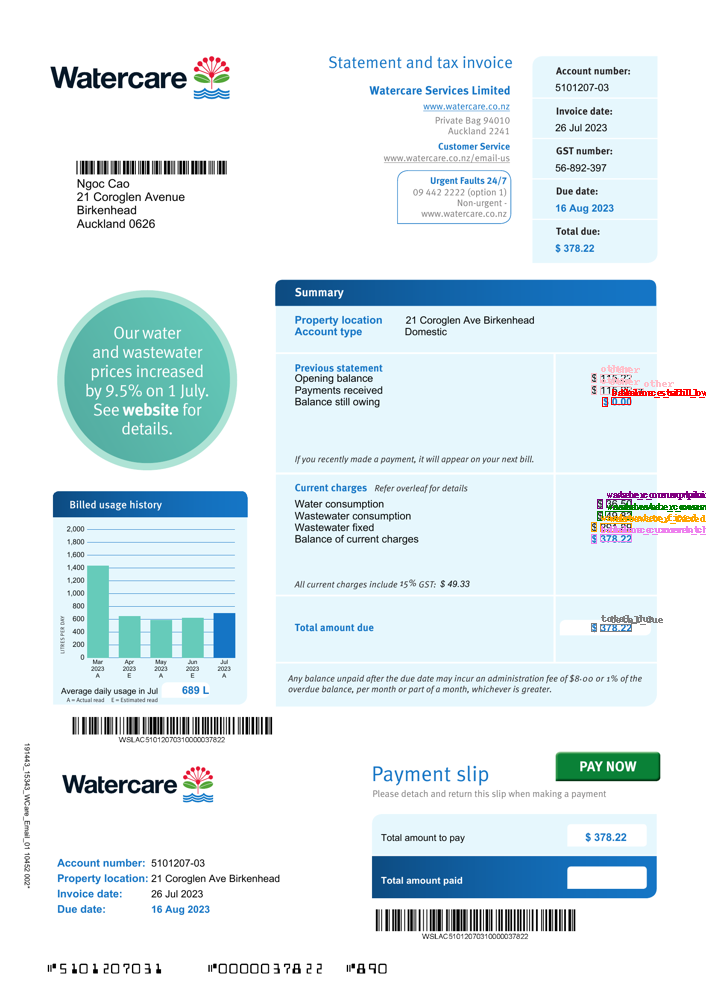

In [34]:
from PIL import ImageDraw, ImageFont

# Visualise prediction
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'other':'pink','balance_still_owing':'red', 'water_consumption':'purple', 'wastewater_consumption':'green', 'wastewater_fixed':'orange', 'balance_current_charges':'violet',
              "total_due": "grey",'water_consumption_details':'red','wastewater_consumption_details':'purple','wastewater_fixed_details':'green','her':'black'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)
image

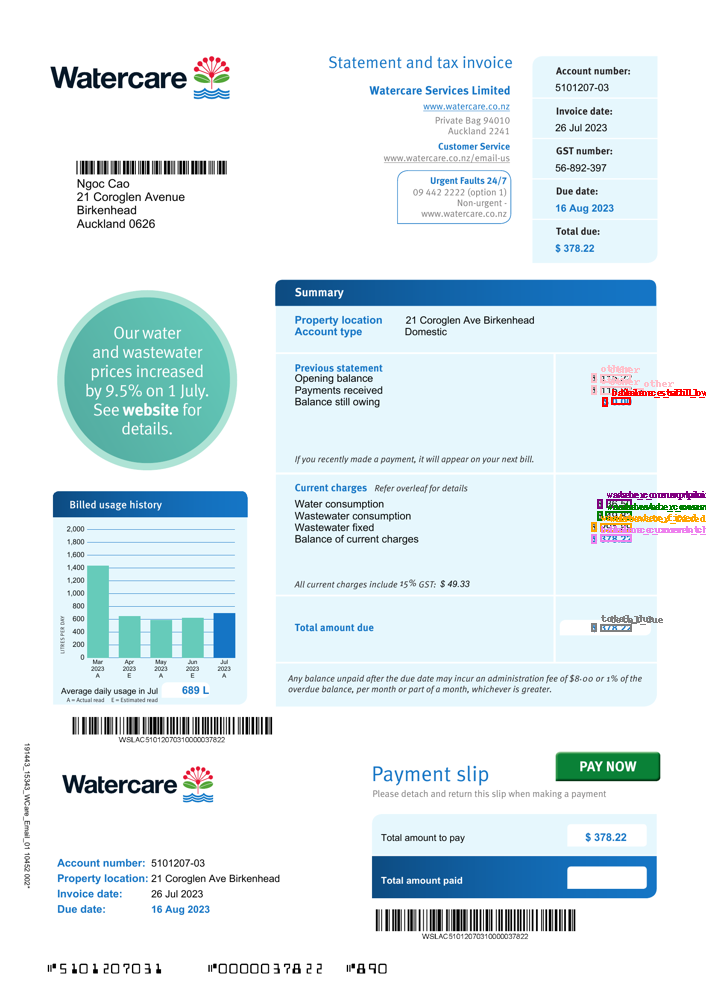

In [35]:
# Compare with ground truth
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image